In [71]:
import torch
from collections import OrderedDict
from codes.metrics import *
import torch.nn.functional as F

class DNN(torch.nn.Module):
    def __init__(self, layers, dropout=0.1):
        super(DNN, self).__init__()

        # parameters
        self.depth = len(layers) - 1

        # set up layer order dict
        self.activation = torch.nn.Tanh

        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1],bias=True))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            layer_list.append(('dropout_%d' % i,torch.nn.Dropout(dropout)))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )

        # deploy layers
        self.layers = torch.nn.Sequential(OrderedDict(layer_list))

    def forward(self, x):
        out = self.layers(x)
        return out
    
def training(model,optimizer, max_epoch,B_0,B_1,bin_width,numBins,W,sigma,alpha,beta, print_epoch =50):
    for epoch in range(max_epoch+1):
        model.train()
        optimizer.zero_grad()
        
        h_pred = F.sigmoid(model(s))
        wsp = weighted_statistical_disparity_torch( h_pred.reshape(1,-1).t(), B_0, B_1, bin_width)

        loss = sigma*torch.sum((h_pred - s)**2) + alpha*wsp + beta*(torch.sum(torch.mm(W,h_pred.reshape(1,-1).t()))/adj.shape[0])
        
        if epoch % print_epoch == 0 :
            result = evaluate(h_pred.detach().numpy(), y, s, prt, W.numpy(), numBins = numBins, bin_width = bin_width,print_flag=0)
            print("Epoch: %5d  || Loss: %.4f || prec: %.6f |  Rank corr: %.6f  | fp: %.6f | wsd: %.6f | wrd: %.6f )" % (epoch, loss.item(), result['precision'], result['corr'], result['fairperception'], result['wsd'] ,result['wrd']))
            
        loss.backward()
        optimizer.step()
        
    return h_pred.detach().numpy(), evaluate(h_pred.detach().numpy(), y, s, prt, W.numpy(),B_0=B_0.numpy(),B_1=B_1.numpy(), numBins = numBins, bin_width = bin_width,print_flag=0)

In [72]:
import sys
import numpy as np
import pandas as pd

from fairsearchcore.models import FairScoreDoc
import fairsearchcore as fsc
#from codes.alg import FPRank, FSPR_model, best_FPRank
from codes.metrics import evaluate
from codes.data_loader import load_data
import matplotlib.pyplot as plt

######################################################################
# Column names
######################################################################

data = 'ICLR2017'
prt_attr = 'famous'
class_attr = 'h_c'
score_attr = 's'

######################################################################
# Configuration parameters
######################################################################

numBins = 10
bin_width = 0.1
score_norm = 10

filename = 'data/' + data
output_file = './results/' + data

adj, data, W, s, y, prt = load_data(filename, class_attr, score_attr, prt_attr, score_norm = score_norm)
B_0, B_1 = generate_bins_matrix(s,prt,numBins)
B_0 = torch.tensor(B_0).type(dtype = torch.float32)
B_1 = torch.tensor(B_1).type(dtype = torch.float32)
s = torch.tensor(s).type(dtype = torch.float32)
W = torch.tensor(W).type(dtype = torch.float32) - torch.eye(adj.shape[0])

In [73]:
max_epoch = 1000
layers = [s.shape[0],256,256,256,s.shape[0]]
lr = 0.0001
weight_decay = 1e-5
alpha_lt = [1]
beta_lt = [0.01,0.1,0.5,1,2,3,4,5,10,20,30,40,50,100,1000]
sigma=1
result_lt=[]
params = {'alpha': list(), 'beta': list()}
results = {'corr': list(), 'precision': list(), 'fairperception': list(), 'wsd': list(), 'wrd': list(), 'h': list()}

In [74]:
for i in range(len(alpha_lt)):
    alpha = alpha_lt[i]
    for j in range(len(beta_lt)):
        beta = beta_lt[j]
        params['alpha'].append(alpha)
        params['beta'].append(beta)
        print("Alpha: ", alpha, 'Beta: ', beta)
        model = DNN(layers, dropout=0.0)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        h, result = training(model,optimizer, max_epoch,B_0,B_1,bin_width,numBins,W,sigma,alpha,beta)
        print("Finished! Results: -->|| prec: %.6f |  Rank corr: %.6f  | fp: %.6f | wsd: %.6f | wrd: %.6f )" % (result['precision'], result['corr'], result['fairperception'], result['wsd'],result['wrd']))
        
        results['h'].append(h)
        results['corr'].append(result['corr'])
        results['precision'].append(result['precision'])
        results['fairperception'].append(result['fairperception'])
        results['wsd'].append(result['wsd'])
        results['wrd'].append(result['wrd'])
        
        result_lt.append(result)

Alpha:  1 Beta:  0.01
Epoch:     0  || Loss: 11.9102 || prec: 0.477299 |  Rank corr: -0.046676  | fp: 1.000000 | wsd: 0.610387 | wrd: 0.646229 )
Epoch:    50  || Loss: 1.1766 || prec: 0.927782 |  Rank corr: 0.973003  | fp: 1.000000 | wsd: 0.519718 | wrd: 0.273101 )
Epoch:   100  || Loss: 0.7635 || prec: 0.933622 |  Rank corr: 0.990915  | fp: 0.997951 | wsd: 0.499709 | wrd: 0.280955 )
Epoch:   150  || Loss: 0.7522 || prec: 0.934886 |  Rank corr: 0.991229  | fp: 0.997951 | wsd: 0.495843 | wrd: 0.317891 )
Epoch:   200  || Loss: 0.7523 || prec: 0.935680 |  Rank corr: 0.991304  | fp: 0.997951 | wsd: 0.495455 | wrd: 0.328469 )
Epoch:   250  || Loss: 0.7516 || prec: 0.933279 |  Rank corr: 0.990963  | fp: 0.997951 | wsd: 0.496272 | wrd: 0.307232 )
Epoch:   300  || Loss: 0.7525 || prec: 0.934154 |  Rank corr: 0.991267  | fp: 0.997951 | wsd: 0.496978 | wrd: 0.330316 )
Epoch:   350  || Loss: 0.7514 || prec: 0.935326 |  Rank corr: 0.990963  | fp: 0.997951 | wsd: 0.496690 | wrd: 0.309972 )
Epoch:  

In [75]:
precision_lt =[]
fair_p =[]
wsd_lt = []
wrd_lt = []
for result in result_lt:
    precision_lt.append(result['precision'])
    fair_p.append(result['fairperception'])
    wsd_lt.append(result['wsd'])
    wrd_lt.append(result['wrd'])

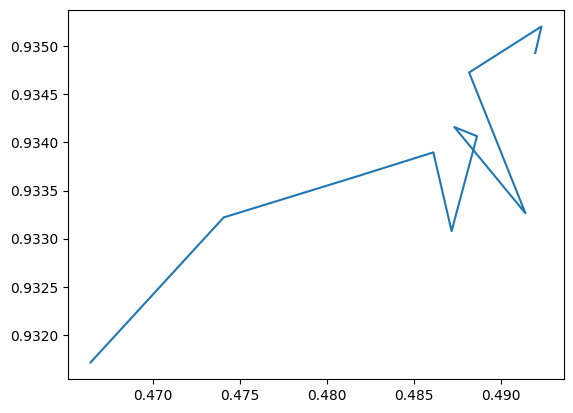

In [76]:
plt.plot(wsd_lt[:11],precision_lt[:11])
plt.show()

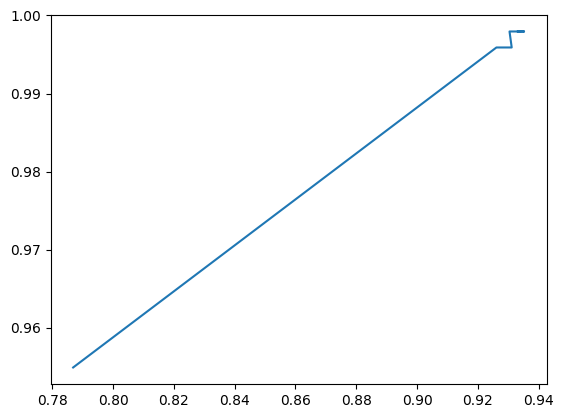

In [77]:
plt.plot(precision_lt,fair_p)
plt.show()

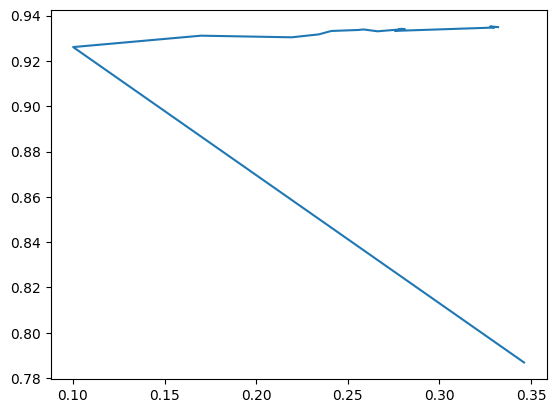

In [78]:
plt.plot(wrd_lt,precision_lt)
plt.show()


Best parameters: alpha = 1.0000, beta = 100.0000 (util = 0.8915)

  prec: 0.926111 |  Rank corr: 0.979025  | fp: 0.995902 | wsd: 0.415815 | wrd: 0.100146
|| prec: 0.926111 |  Rank corr: 0.979025  | fp: 0.995902 | wsd: 0.415815 | wrd: 0.100146 )


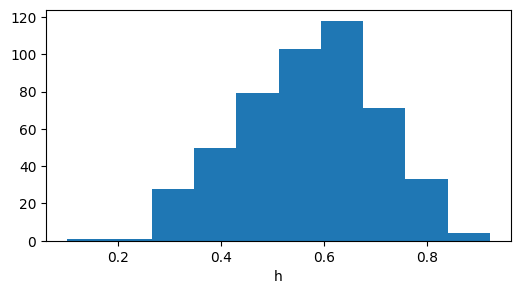

In [79]:
from codes.alg import *
h,best_param,utils = best_FPRank(results, params, criterion = 'pmean', toRank=False)
result = evaluate(h, y, s, prt, W.numpy(),B_0.numpy(),B_1.numpy(), numBins = numBins, bin_width = bin_width,print_flag=1)
print("|| prec: %.6f |  Rank corr: %.6f  | fp: %.6f | wsd: %.6f | wrd: %.6f )" % (result['precision'], result['corr'], result['fairperception'], result['wsd'] ,result['wrd']))

ValueError: x and y must have same first dimension, but have shapes (1,) and (15,)

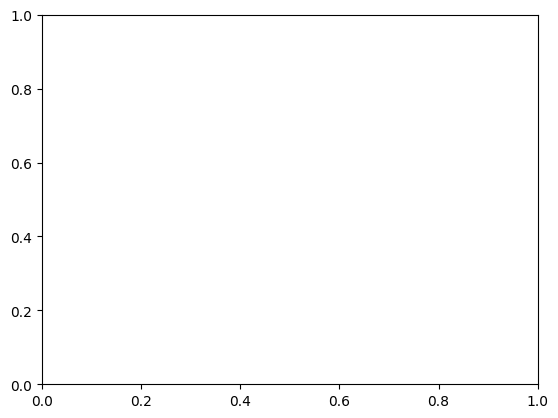

In [80]:
plt.plot(alpha_lt,precision_lt)
plt.plot(alpha_lt,wsd_lt)
plt.show()

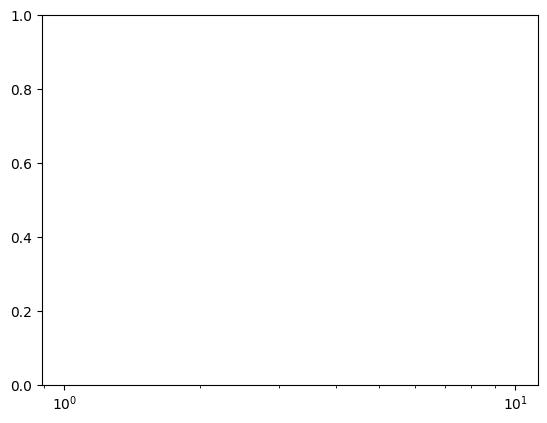

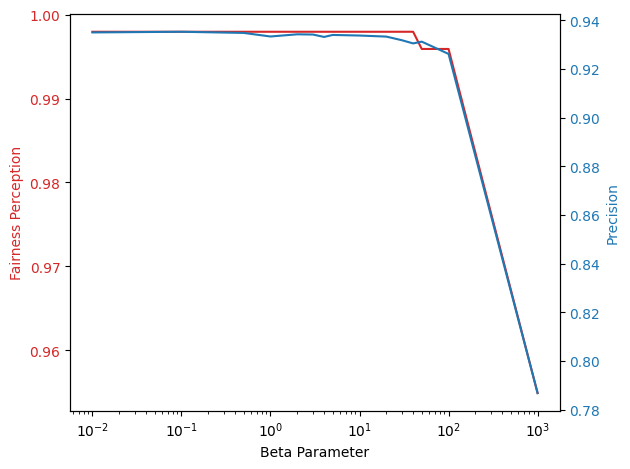

In [87]:
plt.xscale("log")
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Beta Parameter')
ax1.set_ylabel('Fairness Perception', color=color)
ax1.plot(beta_lt, fair_p, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Precision', color=color)  # we already handled the x-label with ax1
ax2.plot(beta_lt, precision_lt, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.xscale("log")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()